In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import matplotlib.patches as patches
%matplotlib inline
import json
import glob
import numpy as np
from PIL import Image
import rasterio
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
from rasterio.plot import show_hist
#from scipy.misc import imsave
from imageio import imwrite
from sklearn.cluster import DBSCAN
from shapely.geometry import box
Image.MAX_IMAGE_PIXELS = None
import tifffile as tiff

In [8]:
liebre1_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_histeq2.tif"
liebre1_box_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/liebre1_boxes.geojson"

In [9]:
#visualise histogram:

rasterio_image = rasterio.open(liebre1_image_path)

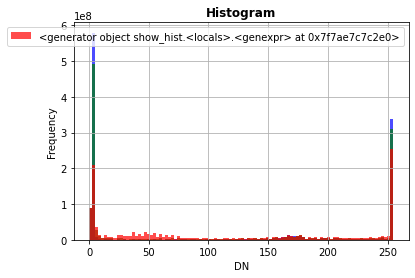

In [10]:
show_hist(rasterio_image, bins = 100 , lw=0.0, stacked = False, alpha=0.7, histtype= 'stepfilled')

In [11]:
image_array = tiff.imread(liebre1_image_path)

In [12]:
print(image_array.max())
image_array

255


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [250, 255, 255],
        [249, 255, 255],
        [231, 233, 255]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [239, 245, 255],
        [213, 205, 215],
        [210, 201, 210]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [220, 214, 233],
        [200, 190, 190],
        [214, 206, 217]]

In [13]:
PIL_image = Image.fromarray(image_array)

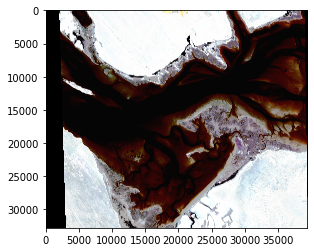

In [14]:
plt.imshow(PIL_image)

In [15]:
from src.preprocessing.dataprocessing import convert_coords, save_files, read_coords

In [17]:
file_save_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/hist_eq_test"
geotif = rasterio_image

<class 'PIL.Image.Image'>


KeyboardInterrupt: 

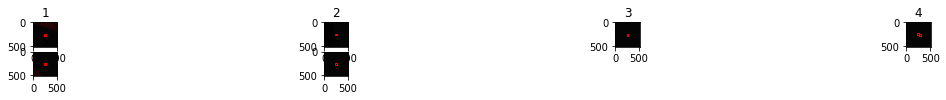

In [18]:
with open(liebre1_box_path, 'r') as f:
    label = json.load(f)
    image = PIL_image
    print(type(image))

    coords, centres = read_coords(label)
    
    # convert bounding box coordinates from geographic to image-scaled
    centres_converted = np.array([convert_coords(image, geotif, label, point[0], point[1]) for point in centres])
    
    coords_converted = np.array([[convert_coords(image, geotif, label, point[0][0], point[0][1]), 
                                  convert_coords(image, geotif, label, point[1][0], point[1][1])] 
                            for point in coords
                       ])    
    
    ## DB-Scan algorithm for clustering ##
    
    eps = 250 # threshold distance between two points to be in the same 'neighbourhood'
    dbscan = DBSCAN(min_samples=1, eps=eps)
    y = dbscan.fit_predict(centres_converted)

    # storing coordinates of clusters, relative to boundaries of image (not tile)
    info = {}
    for i in range(y.max()+1):
        
        # calculate the max and min coords of all the bounding boxes in the cluster
        box_centres = centres_converted[np.where(y==i)[0]]
        min_x, max_x = box_centres[:, 0].min(), box_centres[:, 0].max()
        min_y, max_y = box_centres[:, 1].min(), box_centres[:, 1].max()
        
        # assign each cluster of objects as an item
        item = {}
        item['centre'] = [(min_x+max_x)//2, (min_y+max_y)//2]
        item['object_boxes'] = coords_converted[np.where(y==i)[0]].tolist()
        item['name'] = "whale"
        info[i] = item
        
        # add a line here to generalize to multiple categories:
        # if label['features']['NumShip'] == ... : 

    save_files(image, label, info, file_save_path, 'liebre1')

In [22]:
#Visualise some of the saved files:
cropped_image_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/hist_eq_test/liebre1_0.png"
cropped_label_path = "/gws/nopw/j04/ai4er/users/kmgreen/data/hist_eq_test/liebre1_0.txt"

In [20]:
cropped_image = Image.open(cropped_image_path)

In [23]:
import pandas as pd 
boxes = pd.read_csv(cropped_label_path, sep=" ", header=None)

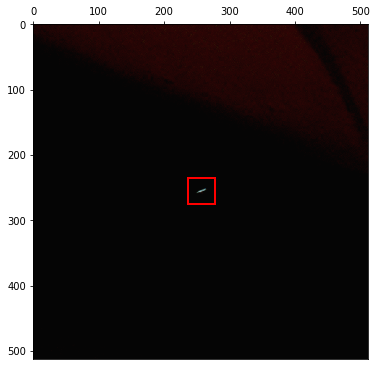

In [24]:
x = (boxes[1][0] - boxes[3][0]*0.5)*cropped_image.size[0]
y = (boxes[2][0] - boxes[4][0]*0.5)*cropped_image.size[1]
w = boxes[3][0] * cropped_image.size[0]
h = boxes[4][0] * cropped_image.size[1]
fig, ax = plt.subplots(figsize = (6,9))
ax.xaxis.tick_top()
ax.imshow(cropped_image)
ax.add_patch(patches.Rectangle((x,y),w,h, fill=False, edgecolor='red', lw=2))

In [29]:
cropped_image_array = np.array(cropped_image)

In [31]:
cropped_image_array.shape

(512, 512, 3)

In [32]:
cropped_image_array

array([[[27,  5,  5],
        [33,  5,  5],
        [27,  5,  5],
        ...,
        [37,  5,  5],
        [34,  5,  5],
        [21,  5,  5]],

       [[23,  5,  5],
        [24,  5,  5],
        [16,  5,  5],
        ...,
        [31,  5,  5],
        [17,  5,  5],
        [31,  5,  5]],

       [[29,  5,  5],
        [16,  5,  5],
        [21,  5,  5],
        ...,
        [30,  5,  5],
        [28,  5,  5],
        [33,  5,  5]],

       ...,

       [[ 5,  5,  5],
        [ 6,  5,  5],
        [ 5,  5,  5],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]],

       [[ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5],
        ...,
        [ 5,  5,  5],
        [ 5,  5,  5],
        [ 5,  5,  5]]], dtype=uint8)

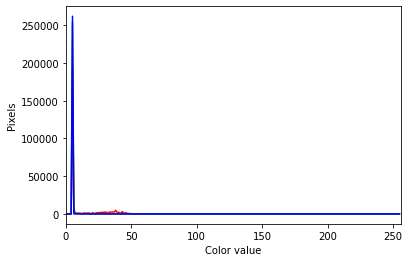

In [33]:
# tuple to select colors of each channel line
colors = ("r", "g", "b")
channel_ids = (0, 1, 2)

# create the histogram plot, with three lines, one for
# each color
plt.xlim([0, 256])
for channel_id, c in zip(channel_ids, colors):
    histogram, bin_edges = np.histogram(
        cropped_image_array[:, :, channel_id], bins=256, range=(0, 256)
    )
    plt.plot(bin_edges[0:-1], histogram, color=c)

plt.xlabel("Color value")
plt.ylabel("Pixels")

plt.show()

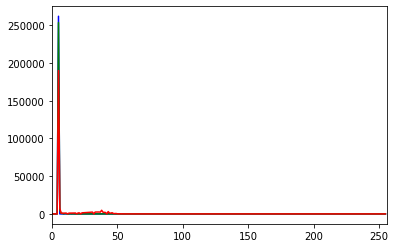

In [34]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = cv2.imread(cropped_image_path)
color = ('b','g','r')
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()